In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score , confusion_matrix
from torchvision.models import VGG16_Weights
import seaborn as sns

# Upload & Read Data

In [ ]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 123
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
device

device(type='cuda', index=0)

In [ ]:
MSS_train = '/content/drive/MyDrive/MSS_train'
MSI_train = '/content/drive/MyDrive/MSI_train'

In [ ]:
print(f'Number of Microsatellite Stability images - train folder: {len(os.listdir(MSS_train))}')
print(f'Number of Microsatellite Instability - train folder: {len(os.listdir(MSI_train))}')

Number of Microsatellite Stability images - train folder: 596
Number of Microsatellite Instability - train folder: 603


In [ ]:
MSS_test = '/content/drive/MyDrive/MSS_test'
MSI_test = '/content/drive/MyDrive/MSI_test'

In [ ]:
print(f'Number of Microsatellite Stability images - test folder: {len(os.listdir(MSS_test))}')
print(f'Number of Microsatellite Instability images - test folder: {len(os.listdir(MSI_test))}')

Number of Microsatellite Stability images - test folder: 403
Number of Microsatellite Instability images - test folder: 463


In [ ]:
MSS_val = '/content/drive/MyDrive/MSS_val'
MSI_val = '/content/drive/MyDrive/MSI_val'

In [ ]:
print(f'Number of Microsatellite Stability images - test folder: {len(os.listdir(MSS_val))}')
print(f'Number of Microsatellite Instability images - test folder: {len(os.listdir(MSI_val))}')

Number of Microsatellite Stability images - test folder: 210
Number of Microsatellite Instability images - test folder: 205


**Defining Data augmentation and normalization for training using transforms**

> Resize image to (224, 244)

> Normalize the image demistion to (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [ ]:
data_transforms = transforms.Compose([
    #resizes the input image to the specified size of (224, 224) pixels.
    transforms.Resize((224, 224)),
    #Convert Image to Pytorch tensor
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

**Load the datasets with ImageFolder**

In [ ]:
# ImageFolder: PyTorch utility for loading image data
train_data = ImageFolder(root='/content/drive/MyDrive/train_GC', transform=data_transforms)
test_data = ImageFolder(root='/content/drive/MyDrive/test_GC', transform=data_transforms)
val_data = ImageFolder(root='/content/drive/MyDrive/val_GC', transform=data_transforms)

# **Create a classifier using pre-trained model from pytorch - ResNet**


# **On Val Test**

First combination lr= 0.003  wd=0.001 momentom=0.5 batch size= 64

In [ ]:
#data loaders with batch size 64
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

# resnet18 model
model = models.resnet18(pretrained=True)

# Modify the classifier for classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Use GPU if available
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, weight_decay=0.001, momentum=0.5)

# Training
num_epochs = 10
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # val
    model.eval()
    correct_val= 0
    total_val = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_accuracy = correct_val/ total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

print(f'Training Accuracy: {train_accuracies[-1]:.4f}')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 107MB/s]


Epoch 0/9, Loss: 0.7160, Train Accuracy: 0.5054, val Accuracy: 0.5831
Epoch 1/9, Loss: 0.6299, Train Accuracy: 0.6364, val Accuracy: 0.6145
Epoch 2/9, Loss: 0.5706, Train Accuracy: 0.7314, val Accuracy: 0.6337
Epoch 3/9, Loss: 0.5157, Train Accuracy: 0.8040, val Accuracy: 0.6675
Epoch 4/9, Loss: 0.4606, Train Accuracy: 0.8349, val Accuracy: 0.6723
Epoch 5/9, Loss: 0.4148, Train Accuracy: 0.8624, val Accuracy: 0.6578
Epoch 6/9, Loss: 0.3546, Train Accuracy: 0.9091, val Accuracy: 0.6771
Epoch 7/9, Loss: 0.2918, Train Accuracy: 0.9500, val Accuracy: 0.6795
Epoch 8/9, Loss: 0.2484, Train Accuracy: 0.9516, val Accuracy: 0.6771
Epoch 9/9, Loss: 0.2057, Train Accuracy: 0.9725, val Accuracy: 0.6747
Training Accuracy: 0.9725


In [ ]:
# Calculate  overall accuracy
overall_accuracy = accuracy_score(all_labels, all_preds)
print(f'Overall Accuracy on val Set: {overall_accuracy:.4f}')

Overall Accuracy on val Set: 0.6747


Second combination lr= 0.001 wd=0.005 momentom=0.7 batch size= 32

In [ ]:
#data loaders with batch size 32
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# resnet18 model
model = models.resnet18(pretrained=True)

# Modify the classifier for classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Use GPU if available
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=0.005, momentum=0.7)

# Training
num_epochs = 10
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # val
    model.eval()
    correct_val= 0
    total_val = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_accuracy = correct_val/ total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

print(f'Training Accuracy: {train_accuracies[-1]:.4f}')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/9, Loss: 0.7150, Train Accuracy: 0.5313
Epoch 1/9, Loss: 0.6173, Train Accuracy: 0.6589
Epoch 2/9, Loss: 0.5780, Train Accuracy: 0.7056
Epoch 3/9, Loss: 0.5128, Train Accuracy: 0.7698
Epoch 4/9, Loss: 0.4483, Train Accuracy: 0.8374
Epoch 5/9, Loss: 0.3992, Train Accuracy: 0.8649
Epoch 6/9, Loss: 0.3472, Train Accuracy: 0.8974
Epoch 7/9, Loss: 0.2843, Train Accuracy: 0.9408
Epoch 8/9, Loss: 0.2353, Train Accuracy: 0.9558
Epoch 9/9, Loss: 0.2051, Train Accuracy: 0.9666
Training Accuracy: 0.9666


In [ ]:
# Calculate overall accuracy
overall_accuracy = accuracy_score(all_labels, all_preds)
print(f'Overall Accuracy on val Set: {overall_accuracy:.4f}')

Overall Accuracy on val Set: 0.6940


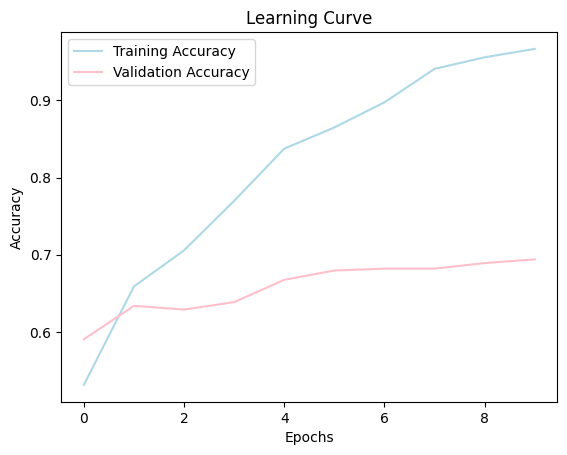

Training Accuracy: 0.9666
Validation Accuracy: 0.6940


In [ ]:
# learning curve
plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy',color='lightblue')
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy',color='pink')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

print(f'Training Accuracy: {train_accuracies[-1]:.4f}')
print(f'Validation Accuracy: {val_accuracies[-1]:.4f}')

Third combination lr= 0.001 wd=0.01 momentom=0.7 batch size= 64

In [ ]:
# data loaders with batch size 64
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

# resnet18 model
model = models.resnet18(pretrained=True)

# Modify the classifier forclassification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Use GPU if available
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=0.01, momentum=0.7)

# Training
num_epochs = 10
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # val
    model.eval()
    correct_val= 0
    total_val = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_accuracy = correct_val/ total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

print(f'Training Accuracy: {train_accuracies[-1]:.4f}')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/9, Loss: 0.7406, Train Accuracy: 0.4846
Epoch 1/9, Loss: 0.6703, Train Accuracy: 0.5771
Epoch 2/9, Loss: 0.6209, Train Accuracy: 0.6639
Epoch 3/9, Loss: 0.5842, Train Accuracy: 0.7289
Epoch 4/9, Loss: 0.5488, Train Accuracy: 0.7548
Epoch 5/9, Loss: 0.5128, Train Accuracy: 0.7965
Epoch 6/9, Loss: 0.4811, Train Accuracy: 0.8307
Epoch 7/9, Loss: 0.4477, Train Accuracy: 0.8649
Epoch 8/9, Loss: 0.4115, Train Accuracy: 0.8782
Epoch 9/9, Loss: 0.3839, Train Accuracy: 0.9049
Training Accuracy: 0.9049


In [ ]:
# Calculate  overall accuracy
overall_accuracy = accuracy_score(all_labels, all_preds)
print(f'Overall Accuracy on val Set: {overall_accuracy:.4f}')

Overall Accuracy on val Set: 0.6554


Fourth combination lr= 0.003 wd=0.001 momentom=0.5 batch size= 128

In [ ]:
#  data loaders with batch size 128
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False)

# resnet18 model
model = models.resnet18(pretrained=True)

# Modify the classifier binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Use GPU if available
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, weight_decay=0.001, momentum=0.5)

# Training
num_epochs = 10
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # val
    model.eval()
    correct_val= 0
    total_val = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_accuracy = correct_val/ total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

print(f'Training Accuracy: {train_accuracies[-1]:.4f}')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/9, Loss: 0.7525, Train Accuracy: 0.5054
Epoch 1/9, Loss: 0.6706, Train Accuracy: 0.5888
Epoch 2/9, Loss: 0.6210, Train Accuracy: 0.6772
Epoch 3/9, Loss: 0.5830, Train Accuracy: 0.7148
Epoch 4/9, Loss: 0.5520, Train Accuracy: 0.7606
Epoch 5/9, Loss: 0.5154, Train Accuracy: 0.8015
Epoch 6/9, Loss: 0.4765, Train Accuracy: 0.8340
Epoch 7/9, Loss: 0.4547, Train Accuracy: 0.8357
Epoch 8/9, Loss: 0.4180, Train Accuracy: 0.8832
Epoch 9/9, Loss: 0.3893, Train Accuracy: 0.8924
Training Accuracy: 0.8924


In [ ]:
# Calculate overall accuracy
overall_accuracy = accuracy_score(all_labels, all_preds)
print(f'Overall Accuracy on val Set: {overall_accuracy:.4f}')

Overall Accuracy on val Set: 0.6723


# **On Test Set**

In [ ]:
import torch
from torch import nn, optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import numpy as np
import matplotlib.pyplot as plt
import time
import os

In [ ]:
#data loaders with batch size 32
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# resnet18 model
model = models.resnet18(pretrained=True)

# Modify the classifier for  classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

#  model parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters in the model: {num_params}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),  lr=0.001, weight_decay=0.005, momentum=0.7)

# Training
num_epochs = 10
train_accuracies = []
test_accuracies = []

# Start training time
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Testing
    model.eval()
    correct_test= 0
    total_test = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = correct_test/ total_test
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

# Calculate  training time
total_time = time.time() - start_time
print(f"Total training time: {total_time:.2f} seconds")

# Save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/your_trained_model.pth')

#  final training accuracy
print(f'Training Accuracy: {train_accuracies[-1]:.4f}')

# Calculate  confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print(f'Confusion Matrix:\n{conf_matrix}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 151MB/s]


Number of parameters in the model: 11177538
Epoch 0/9, Loss: 0.7099, Train Accuracy: 0.5229
Epoch 1/9, Loss: 0.6287, Train Accuracy: 0.6405
Epoch 2/9, Loss: 0.5830, Train Accuracy: 0.7123
Epoch 3/9, Loss: 0.5207, Train Accuracy: 0.7765
Epoch 4/9, Loss: 0.4699, Train Accuracy: 0.8090
Epoch 5/9, Loss: 0.4086, Train Accuracy: 0.8649
Epoch 6/9, Loss: 0.3540, Train Accuracy: 0.9016
Epoch 7/9, Loss: 0.3018, Train Accuracy: 0.9191
Epoch 8/9, Loss: 0.2525, Train Accuracy: 0.9450
Epoch 9/9, Loss: 0.2121, Train Accuracy: 0.9575
Total training time: 593.72 seconds
Training Accuracy: 0.9575
Confusion Matrix:
[[351 112]
 [166 237]]


In [ ]:
# Calculate overall accuracy
overall_accuracy = accuracy_score(all_labels, all_preds)
print(f'Overall Accuracy on Test Set: {overall_accuracy:.4f}')

# Calculate classification report
class_report = classification_report(all_labels, all_preds)
print(f'Classification Report:\n{class_report}')

Overall Accuracy on Test Set: 0.6790
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.76      0.72       463
           1       0.68      0.59      0.63       403

    accuracy                           0.68       866
   macro avg       0.68      0.67      0.67       866
weighted avg       0.68      0.68      0.68       866



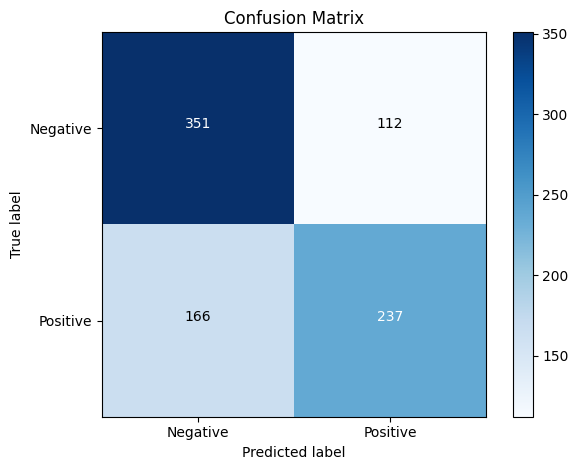

In [ ]:
# confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# labels
classes = ['Negative', 'Positive']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# text annotations
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()


# **Interface**

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predicted class: MSI
Image: /content/drive/MyDrive/load images/blk-AQVCIQDISFQG-TCGA-D5-6530-01Z-00-DX1.jpg, Predicted Class: MSI
Predicted class: MSS
Image: /content/drive/MyDrive/load images/blk-AQLWTDNCDGIM-TCGA-CM-6171-01Z-00-DX1.jpg, Predicted Class: MSS
Predicted class: MSS
Image: /content/drive/MyDrive/load images/blk-AQMWRCKLLDEK-TCGA-NH-A5IV-01Z-00-DX1.jpg, Predicted Class: MSS
Predicted class: MSS
Image: /content/drive/MyDrive/load images/blk-AQSNLFLWKRDR-TCGA-CM-4743-01Z-00-DX1.jpg, Predicted Class: MSS
Predicted class: MSS
Image: /content/drive/MyDrive/load images/blk-AQTISQRRTKGR-TCGA-G4-6304-01Z-00-DX1.jpg, Predicted Class: MSS
Predicted class: MSI
Image: /content/drive/MyDrive/load images/blk-AQIGPHSNLCHK-TCGA-QG-A5Z2-01Z-00-DX2.jpg, Predicted Class: MSI
Predicted class: MSS
Image: /content/drive/MyDrive/load images/blk-APWSWWVKRGMA-TCGA-AA-3875-01Z-00-DX1.jpg, Predicted Class: MSS
Predicted class: MSI
Image: /content/drive/MyDrive/load images/blk-APVARSWHLQNK-TCGA-CM-58

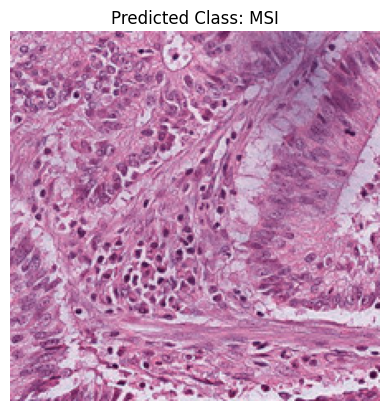

Predicted class: MSS


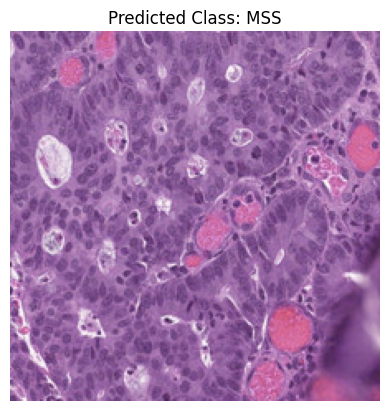

Predicted class: MSS


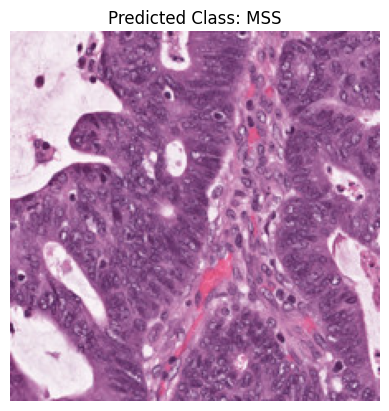

Predicted class: MSS


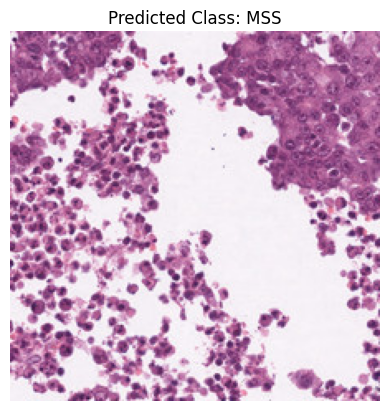

Predicted class: MSS


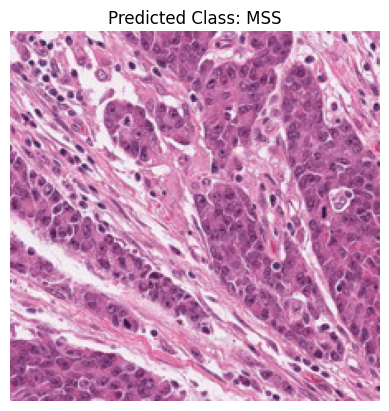

Predicted class: MSI


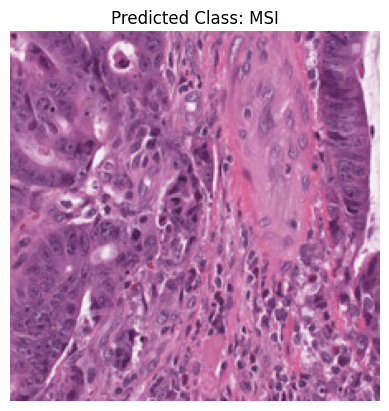

Predicted class: MSS


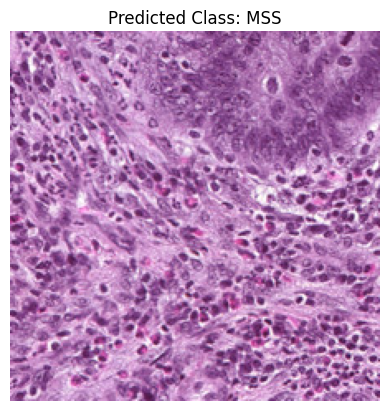

Predicted class: MSI


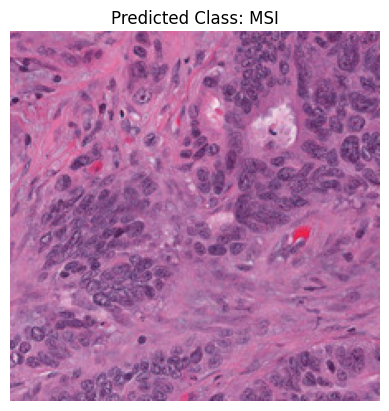

Predicted class: MSI


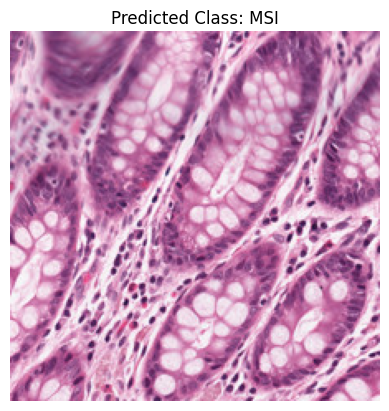

Predicted class: MSS


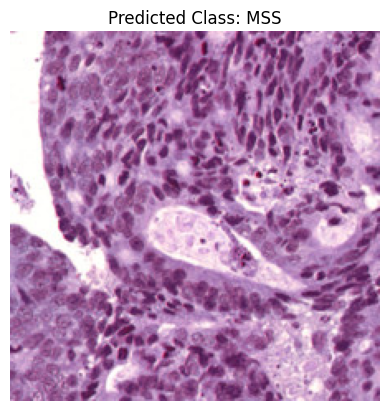

Predicted class: MSS


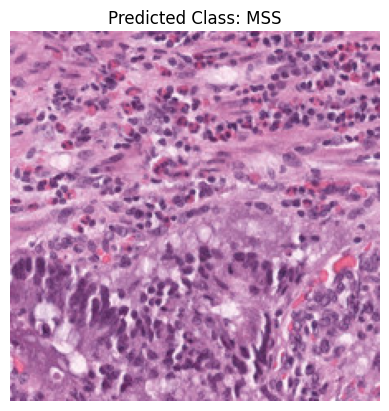

Predicted class: MSI


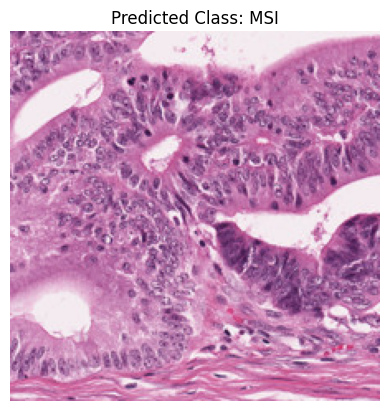

In [ ]:
input_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# resnet18 model
model = models.resnet18(pretrained=True)

# Modify the classifier for classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model.load_state_dict(torch.load('/content/drive/MyDrive/your_trained_model.pth'))
model.eval()

classes = ['MSS', 'MSI']

def predict_image(file_path):
    # Print file path
    #print("Processing image:", file_path)

    img = Image.open(file_path)
    img = input_transform(img)
    img = img.unsqueeze(0)
    with torch.no_grad():
        output = model(img)
        _, predicted = torch.max(output, 1)
        predicted_class = classes[predicted.item()]

    print("Predicted class:", predicted_class)

    return predicted_class

# Directory containing images to classify
image_dir = '/content/drive/MyDrive/load images'

image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]

for image_file in image_files:
    prediction = predict_image(image_file)
    print(f"Image: {image_file}, Predicted Class: {prediction}")


import matplotlib.pyplot as plt

def show_prediction(file_path, predicted_class):
    img = Image.open(file_path)
    plt.imshow(img)
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.show()

for image_file in image_files:
    prediction = predict_image(image_file)
    show_prediction(image_file, prediction)